In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import itertools
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.metrics import coverage_error
from sklearn.svm import SVC
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.neural_network import MLPClassifier
import scipy.sparse
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from bs4 import BeautifulSoup

#from sklearn.preprocessing import StandardScaler

from scipy.sparse import coo_matrix, hstack


# Dataset loading

In [3]:
#Dataset loading
dataset2 = pd.read_csv('Cleaned_Posts.csv', nrows = None, index_col=0)
dataset2.shape

(49399, 10)

In [4]:
#Any np.nan ?
dataset2.isnull().sum()

TText             0
TText_NEG         0
PText             0
TCode         10054
PCode          9627
TTitle            0
TTitle_NEG        0
Title             0
PTags             0
Tags              0
dtype: int64

In [5]:
#np.nan cleaning
dataset2['TCode'] = dataset2['TCode'].fillna('None')
dataset2['PCode'] = dataset2['PCode'].fillna('None')

In [6]:
#Any np.nan ?
dataset2.isnull().sum()

TText         0
TText_NEG     0
PText         0
TCode         0
PCode         0
TTitle        0
TTitle_NEG    0
Title         0
PTags         0
Tags          0
dtype: int64

In [7]:
df = pd.DataFrame(dataset2['PTags'].tolist()).stack().value_counts()
#df = df[df>50]
df.shape

(36578,)

In [8]:
existintags = set(df.index)
existintags

{"['entity-framework', 'asp-net-core-mvc-2.0']",
 "['microsoft-edge']",
 "['gsuite']",
 "['java', 'selenium', 'automated-tests', 'browsermob', 'little-proxy']",
 "['mips', 'swap', 'cpu-architecture', 'qtspim']",
 "['python', 'c++', 'numpy', 'swig']",
 "['mysql', 'bash', 'zsh']",
 "['vba', 'class', 'module']",
 "['c#', 'code-analysis', 'fxcop', 'roslyn-code-analysis']",
 "['ios', 'json', 'swift', 'uitableview', 'swift4']",
 "['annotations', 'kotlin']",
 "['php', 'mysql', 'codeigniter', 'saas']",
 "['c', 'string', 'c99']",
 "['java', 'string', 'java-8', 'optional']",
 "['view', 'controller']",
 "['javascript', 'node.js', 'asynchronous', 'promise']",
 "['machine-learning', 'google-cloud-platform', 'google-cloud-ml']",
 "['postgresql', 'parameters', 'user-defined-aggregate']",
 "['java', 'variables', 'object', 'field']",
 "['node.js', 'postgresql', 'many-to-many', 'sequelize.js']",
 "['semantic-release']",
 "['javascript', 'templating', 'dust.js']",
 "['json', 'wordpress', 'api']",
 "['c++

# Dataset splitting

In [9]:
#Downsampling
dataset = dataset2.sample(10000)
dataset.shape

(10000, 10)

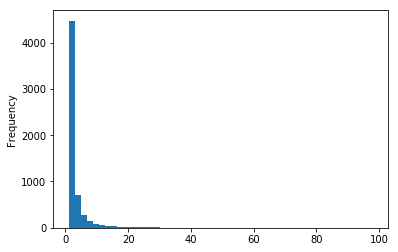

In [10]:
#Most commons tags
dataset['PTags'] = dataset['Tags'].apply(lambda x: [tag.name for tag in BeautifulSoup(x, 'html.parser').find_all()])
df = pd.DataFrame(dataset['PTags'].tolist()).stack().value_counts()
df[df<100].plot(kind = 'hist', bins = 50)
plt.show()

In [11]:
popularitytags = df[df>10].to_dict()
len(popularitytags)

374

In [12]:
#Tags cleaning
textset = dataset.copy()
textset['PTagsCleaned'] = textset['PTags'].apply(lambda x: [tag for tag in x if tag in popularitytags.keys()])
textset['PTagsCleanedLen'] = textset['PTagsCleaned'].apply(lambda x: len(x))
textset = textset[textset['PTagsCleanedLen'] != 0]
textset = textset.dropna()
print(textset.shape)
textset[['PTagsCleaned', 'PTags', 'TCode']].head()

(9027, 12)


,PTagsCleaned,PTags,TCode
Id,,,
48069858,"[python, django, nginx]","[python, django, nginx, digital-ocean, file-sy...",from django . db import models from django . c...
48115976,[android],"[android, progressdialog]",progressDialog = new ProgressDialog ( this ); ...
48052770,"[reactjs, redux, react-redux]","[reactjs, redux, react-redux]",import React from ' react '; import { makeSele...
48182880,[node.js],"[node.js, influxdb]",""" SELECT * FROM Measurement WHERE time >' - - ..."
48060615,"[java, null]","[java, constructor, null, initialization, return]",null A a ;/ / A is some valid user - defined o...


In [13]:
#X set creation
X = textset[['TText', 'TTitle', 'TCode']]

In [14]:
#Label dataset creation

y = textset['PTagsCleaned']

mlb = preprocessing.MultiLabelBinarizer()
Y = mlb.fit_transform(y)
Y.shape

(9027, 374)

In [15]:
#Dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0, shuffle = True)

In [16]:
mlb.classes_

array(['ajax', 'algorithm', 'amazon-ec2', 'amazon-s3',
       'amazon-web-services', 'android', 'android-fragments',
       'android-gradle', 'android-intent', 'android-layout',
       'android-recyclerview', 'android-studio', 'angular', 'angular-cli',
       'angular5', 'angularjs', 'animation', 'apache', 'apache-kafka',
       'apache-spark', 'apache-spark-sql', 'api', 'arraylist', 'arrays',
       'asp.net', 'asp.net-core', 'asp.net-core-2.0', 'asp.net-mvc',
       'asp.net-web-api', 'assembly', 'asynchronous', 'audio',
       'authentication', 'autocomplete', 'automation', 'awk', 'aws-lambda',
       'azure', 'bash', 'batch-file', 'beautifulsoup', 'boost',
       'bootstrap-4', 'browser', 'button', 'c', 'c#', 'c++', 'c++11',
       'caching', 'canvas', 'cassandra', 'charts', 'checkbox', 'class',
       'cloud', 'cmake', 'cmd', 'codeigniter', 'computer-vision',
       'cookies', 'cordova', 'cors', 'cron', 'css', 'css3', 'csv', 'curl',
       'd3.js', 'database', 'dataframe', 'datata

# LDA version

In [187]:

class CustomLDA(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_1_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_2_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_3_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.lda_params = {'n_components':10, 'random_state':0, 'doc_topic_prior':None, 'topic_word_prior':None}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5, 'popmax':.15, 'merge':False, 'serie':[]}
        
        self.params = {**{'vect_1_'+k:v for k,v in self.vect_1_params.items()},
                       **{'vect_2_'+k:v for k,v in self.vect_2_params.items()},
                       **{'vect_3_'+k:v for k,v in self.vect_2_params.items()},
                       **{'lda_'+k:v for k,v in self.lda_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        self.nametopics()
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
        
    
    def fit(self, X, y):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        self.cvect1 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_1_params)
        cvect1 = self.cvect1.fit_transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            self.cvect2 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_2_params)
            cvect2 = self.cvect2.fit_transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            self.cvect3 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_3_params)
            cvect3 = self.cvect3.fit_transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        

        
        #LDA preparation
        self.lda = LatentDirichletAllocation(learning_method = 'batch', **self.lda_params)
        self.lda.fit(Xtrans)
        
        self.components_ = self.lda.components_
        
        self.nametopics()
        self.topic_popularity(X)
        
        return self
    
    def transformcvect(self, X, y=None):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        cvect1 = self.cvect1.transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            cvect2 = self.cvect2.transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            cvect3 = self.cvect3.transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        
        return Xtrans
        
    def transform(self, X, y=None):
        lda = self.lda.transform(self.transformcvect(X))
        return lda
    
    def get_feature_names(self):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        toreturn = []
        
        if merge or len(serie) >= 1:
            toreturn.extend(self.cvect1.get_feature_names())
        if not merge and len(serie) >= 2:
            toreturn.extend(self.cvect2.get_feature_names())
        if not merge and len(serie) >= 3:
            toreturn.extend(self.cvect3.get_feature_names())
        
        return toreturn
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_1_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_1_')}
        self.vect_2_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_2_')}
        self.vect_3_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_3_')}
        
        self.lda_params = {k[4:]:v for k,v in self.params.items() if k.startswith('lda_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.lda_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in popularitytags.keys()]
            for tag in tags:
                if tag in popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self

    def describe_topics(self, ntopwords=None, ntopics=None):
        if not ntopwords:
            ntopwords = self.clf_params['ntopwords']
        if not ntopics:
            ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        toreturn = []
        
        for topicnum, topiccomposition in enumerate(components[:ntopics]):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            toreturn.append(tags)
        
        return np.array(toreturn)
    
    def perplexity(self, X):
        
        return self.lda.perplexity(self.transformcvect(X))
    
    def topic_popularity(self, X):
        self.topic_pop_ = {}
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()
        ntoptopics = 5
        
        for index, document in enumerate(W):
            #select the most important topics
            for topic in document.argsort()[:-ntoptopics-1:-1]:
                if topic not in self.topic_pop_.keys():
                    self.topic_pop_[topic] = 0
                self.topic_pop_[topic] += 1

        limit = self.clf_params['popmax'] * X.shape[0]
        
        self.too_popular_topics = [topic for topic, popularity in self.topic_pop_.items() if popularity > limit]



#customLDA = CustomLDA()


Some docs about the parameters : https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [207]:
topics = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_merge': True,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 1/(topics*.8),
 'lda_n_components': topics,
 'lda_random_state': 0,
 'lda_topic_word_prior': 1/topics,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1),}

customLDA = CustomLDA(**params)
customLDA.fit(X_train, y_train)

CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=1, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1))

In [208]:
#Filling rating
customLDA.score()

47.5

In [209]:
#Main topics
customLDA.describe_topics(ntopwords=10, ntopics=20)

array([['view', 'scroll', 'layout', 'content', 'like', 'set', 'onli',
        'problem', 'need', 'render'],
       ['method', 'get', 'observ', 'use', 'cach', 'code', 'like',
        'asynchron', 'oper', 'realm'],
       ['get', 'use', 'scope', 'ani', 'type', 'creat', 'need', 'follow',
        'want', 'u0_a110'],
       ['window', 'open', 'modal', 'work', 'use', 'ani', 'run', 'script',
        'want', 'like'],
       ['spring', 'token', 'api', 'use', 'boot', 'get', 'return',
        'respons', 'request', 'access'],
       ['cluster', 'get', 'file', 'save', 'creat', 'run', 'pod',
        'kubernet', 'firebas', 'connect'],
       ['data', 'session', 'use', 'like', 'fetch', 'way', 'get', 'want',
        'show', 'expir'],
       ['project', 'build', 'gradl', 'use', 'version', 'problem', 'modul',
        'one', 'updat', 'ani'],
       ['document', 'tri', 'get', 'express', 'code', 'set', 'assign',
        'file', 'refer', 'ani'],
       ['servic', 'googl', 'use', 'regist', 'internet', 'catego

In [210]:
#Perplexity
customLDA.perplexity(X_test)

8370.6942681397813

In [211]:
customLDA.namedtopics

{'ajax': {22},
 'android': {12, 94},
 'angular': {11},
 'apache': {90},
 'api': {4, 42},
 'audio': {39},
 'browser': {23},
 'button': {48},
 'checkbox': {38},
 'class': {29, 59, 63, 88},
 'cloud': {34},
 'css': {60},
 'csv': {80},
 'date': {30},
 'docker': {57},
 'download': {80},
 'email': {87},
 'excel': {58},
 'express': {8},
 'file': {5, 44, 80, 89},
 'filter': {84},
 'function': {55, 69, 82, 93},
 'git': {73},
 'github': {73},
 'graph': {32},
 'hibernate': {90},
 'html': {11, 55, 60, 77},
 'input': {14, 43},
 'java': {12, 90},
 'javascript': {55},
 'json': {15},
 'laravel': {21},
 'list': {72},
 'magento': {70},
 'maven': {95},
 'mysql': {64},
 'object': {15, 88},
 'pdf': {25},
 'php': {21},
 'pip': {81},
 'plot': {61},
 'post': {22},
 'redirect': {23, 37},
 'rest': {42},
 'scroll': {0},
 'select': {62},
 'server': {51, 79, 89, 98},
 'session': {6},
 'spring': {4},
 'sql': {64},
 'string': {68, 69, 82},
 'text': {19, 24},
 'url': {45},
 'video': {39},
 'web': {13},
 'xamarin': {16

# TSNE reduction dimension

In [212]:
#customLDA
X_lda = customLDA.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_lda)

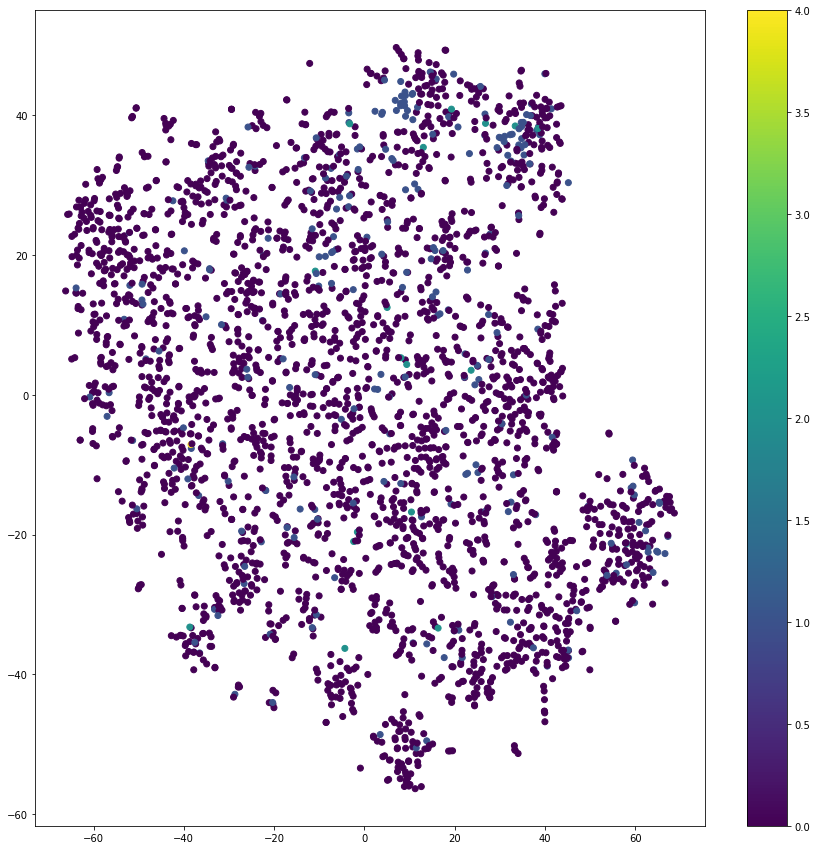

In [214]:
# plot the result
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(X_lda, 0)[:, 0]
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

# GridsearchCV LDA

In [216]:
#gridsearch to optimize the parameters - LDA optimization

topics = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_merge': True,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 1/(topics*.8),
 'lda_n_components': topics,
 'lda_random_state': 0,
 'lda_topic_word_prior': 1/topics,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)
}

customLDA = CustomLDA(**params)

parameters = {'lda_doc_topic_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)],
              'lda_topic_word_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)],
              'clf_merge': [True, False],
             }



clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143 
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143 
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333 
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143, score=35.16666666666667, total=  36.1s
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333, score=49.33333333333333, total=  36.0s
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143, score=48.33333333333333, total=  36.3s
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333 
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.5min


[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.0125, score=52.33333333333333, total=  35.0s
[CV] clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.0125, score=32.33333333333333, total=  35.9s
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666, score=49.83333333333333, total=  36.1s
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666, score=32.0, total=  35.9s
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.008333333333333333 
[CV]  clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143, score=49.833333333333336, total=  35.0s
[CV] clf_merge=True, l

[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed: 10.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'lda_doc_topic_prior': [0.007142857142857143, 0.008333333333333333, 0.01, 0.0125, 0.016666666666666666], 'lda_topic_word_prior': [0.007142857142857143, 0.008333333333333333, 0.01, 0.0125, 0.016666666666666666], 'clf_merge': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [217]:
clf.best_params_

{'clf_merge': True,
 'lda_doc_topic_prior': 0.0125,
 'lda_topic_word_prior': 0.01}

In [218]:
clf.best_score_

45.25

In [219]:
#Parameters update
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.0125,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.01,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)}

# Results comparison --> Unsupervised vs Supervised

In [220]:
#Metrics creation

#from sklearn.metrics import fbeta_score
scorer = make_scorer(f1_score, average='micro')


In [222]:
#gridsearch to optimize the parameters - TEXT merged

customLDA = CustomLDA(**params)

parameters = {'vect_1_max_df': [1., 0.9, 0.95],
              'vect_1_max_features': [15000,18000,12000],
              'vect_1_min_df': [1, 10, 20],
             }

clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring=scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1 ...
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1 ...
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, score=0.08579210167952792, total=  36.5s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, score=0.06352574985851726, total=  40.9s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, score=0.07975705266522816, total=  40.9s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, score=0.10321855686652219, total=  35.4s
[CV] vect_1_max_df=1.0, vect_1_max_features=18000, vect_1_min_df=1 ...


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  6.2min


[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=1, score=0.07975705266522816, total=  42.1s
[CV] vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=10, score=0.10321855686652219, total=  35.6s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1 ...
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20, score=0.08683001531393568, total=  33.8s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1 ...
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20, score=0.10213042771182305, total=  33.6s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10, score=0.08579210167952792, total=  35.7s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1, score=0.06299323562570

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed: 12.3min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect...,
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'vect_1_max_df': [1.0, 0.9, 0.95], 'vect_1_max_features': [15000, 18000, 12000], 'vect_1_min_df': [1, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [223]:
clf.best_score_

0.094505329273025046

In [224]:
clf.best_params_

{'vect_1_max_df': 1.0, 'vect_1_max_features': 15000, 'vect_1_min_df': 10}

In [225]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.10473512198829521

In [226]:
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.0125,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.01,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 10,
 'vect_1_ngram_range': (1, 1)}

In [228]:
#gridsearch to optimize the parameters - LDA optimization - Final round
customLDA = CustomLDA(**params)

parameters = {'lda_doc_topic_prior':[ 1/(topics*0.9), 1/(topics), 1/(topics*0.8), 1/(topics*0.7)],
              'lda_topic_word_prior':[ 1/(topics*1.1), 1/(topics), 1/(topics*0.9), 1/(topics*0.8)],
             }

clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring = scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909 
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909 
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909, score=0.08896505476492064, total=  35.2s
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909, score=0.10335286458333333, total=  35.1s
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01 
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01, score=0.08724881256850565, total=  36.2s
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_top

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.8min


[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.01, score=0.08512505484861782, total=  36.7s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.01, score=0.11150152260482549, total=  36.1s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112, score=0.08462286013306422, total=  36.3s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112, score=0.11170501200712682, total=  36.2s
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125, score=0.08183188572248941, total=  33.0s
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125, score=0.11113734750098386, total=  33.2s


[Parallel(n_jobs=3)]: Done  32 out of  32 | elapsed:  7.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10,
     vec...,
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'lda_doc_topic_prior': [0.011111111111111112, 0.01, 0.0125, 0.014285714285714285], 'lda_topic_word_prior': [0.00909090909090909, 0.01, 0.011111111111111112, 0.0125]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [229]:
clf.best_score_

0.10033142704073042

In [230]:
clf.best_params_

{'lda_doc_topic_prior': 0.0125, 'lda_topic_word_prior': 0.011111111111111112}

In [231]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.10668087049155379

In [232]:
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.0125,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.011111111111111112,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 10,
 'vect_1_ngram_range': (1, 1)}

In [233]:
#Direct calculation


customLDA = CustomLDA(**params)

customLDA.fit(X_train, y_train)

CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0,
     lda_topic_word_prior=0.011111111111111112, vect_1_max_df=1.0,
     vect_1_max_features=15000, vect_1_min_df=10,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=None, vect_2_min_df=1, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1))

In [255]:
customLDA.set_params(clf_popmax=0.11)
customLDA.topic_popularity(X_train)
customLDA.too_popular_topics

[99]

In [256]:
# Topics verification - Too popular
customLDA.describe_topics(ntopwords=20, ntopics=100)[[99]]

array([['filter', 'use', 'work', 'matplotlib', 'code', 'doe', 'scene',
        'compil', 'except', 'list', 'method', 'could', 'understand', 'whi',
        'tri', 'follow', 'sinc', 'exampl', 'guess', 'variabl']],
      dtype='<U12')

In [258]:
# Topics verification - 20 first
customLDA.describe_topics(ntopwords=20, ntopics=20)

array([['div', 'video', 'scroll', 'right', 'top', 'click', 'bottom',
        'left', 'use', 'center', 'like', 'trigger', 'ani', 'css', 'move',
        'tri', 'get', 'would', 'posit', 'content'],
       ['event', 'stop', 'way', 'expand', 'current', 'calendar', 'volum',
        'feed', 'collaps', 'work', 'drag', 'use', 'name', 'past', 'tell',
        'get', 'wo', 'open', 'one', 'code'],
       ['view', 'control', 'chart', 'byte', 'serial', 'set', 'nil',
        'first', 'code', 'back', 'second', 'angularj', 'anoth', 'bar',
        'load', 'problem', 'follow', 'insid', 'one', 'viewcontrol'],
       ['access', 'token', 'use', 'password', 'secur', 'get', 'api',
        'facebook', 'request', 'work', 'auth', 'link', 'login', 'role',
        'need', 'spring', 'account', 'refresh', 'oauth', 'store'],
       ['state', 'updat', 'prop', 'this', 'png', 'chang', 'doe', 'like',
        'textview', 'code', 'differ', 'bound', 'line', 'use', 'approach',
        'tri', 'also', 'subtract', 'problem', 'be

In [259]:
customLDA.topicsnamed

{0: ['video', 'scroll'],
 1: [],
 2: [],
 3: [],
 4: [],
 5: ['post'],
 6: ['function'],
 7: ['csv'],
 8: ['express'],
 9: [],
 10: ['html', 'download', 'ajax'],
 11: [],
 12: ['excel'],
 13: ['file'],
 14: ['input'],
 15: [],
 16: ['plot', 'graph'],
 17: ['null'],
 18: [],
 19: ['lambda'],
 20: [],
 21: [],
 22: ['input'],
 23: ['git'],
 24: ['css'],
 25: ['spring'],
 26: ['file'],
 27: ['file'],
 28: [],
 29: ['typescript'],
 30: ['angular'],
 31: ['design'],
 32: ['listview'],
 33: ['button'],
 34: ['sql', 'mysql'],
 35: ['string', 'regex'],
 36: [],
 37: [],
 38: ['select'],
 39: ['mongodb'],
 40: [],
 41: ['swift'],
 42: ['web'],
 43: [],
 44: [],
 45: ['list', 'xml'],
 46: ['android'],
 47: ['java', 'android'],
 48: ['pdf'],
 49: ['django'],
 50: [],
 51: [],
 52: [],
 53: [],
 54: ['file'],
 55: ['json'],
 56: [],
 57: ['webpack'],
 58: ['android'],
 59: ['file'],
 60: [],
 61: [],
 62: [],
 63: ['python'],
 64: ['server'],
 65: ['api', 'rest'],
 66: ['php', 'html'],
 67: ['date

In [261]:
mlb.inverse_transform(y_test[:10])

[('image-processing', 'matlab'),
 ('javascript',),
 ('npm', 'reactjs'),
 ('c++', 'c++11'),
 ('arrays', 'c', 'multidimensional-array'),
 ('maven',),
 ('api', 'rest'),
 ('javascript', 'react-native', 'react-redux'),
 ('android',),
 ('css3', 'html5', 'jquery')]

In [262]:
customLDA.predict_word(X_test[:10])

array([['error', 'get', 'code', 'help', 'pleas', 'activ', 'result',
        'matrix', 'onli', 'place', 'function', 'remov', 'argument', 'pass',
        'call'],
       ['attribut', 'cluster', 'get', 'solv', 'python', 'order', 'number',
        'count', 'code', 'take', 'data', 'api', 'use', 'get', 'rest'],
       ['use', 'tri', 'stream', 'doe', 'typescript', 'compon', 'react',
        'rout', 'angular', 'render', 'file', 'save', 'code', 'line',
        'creat'],
       ['thread', 'execut', 'wait', 'program', 'start', 'filter', 'use',
        'work', 'matplotlib', 'code', 'set', 'css', 'color', 'work', 'tri'],
       ['function', 'remov', 'argument', 'pass', 'call', 'array', 'like',
        'iter', 'would', 'loop', 'valu', 'variabl', 'return', 'field',
        'get'],
       ['file', 'plugin', 'run', 'use', 'get', 'error', 'project',
        'studio', 'compil', 'android', 'local', 'ex', 'file', 'resourc',
        'sdk'],
       ['data', 'api', 'use', 'get', 'rest', 'instanc', 'aw', 'use'

In [263]:
mlb.inverse_transform(customLDA.predict(X_test[:10]))

[('function', 'matrix'),
 ('api', 'python', 'rest'),
 ('angular', 'file', 'typescript'),
 ('css', 'filter', 'matplotlib'),
 ('function',),
 ('android', 'file'),
 ('api', 'file', 'rest'),
 ('angular',),
 ('button', 'post'),
 ('css', 'html', 'php')]

# NMF version

In [76]:

class CustomNMF(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_1_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_2_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_3_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.nmf_params = {'n_components':10, 'random_state':0, 'init':'nndsvd', 'alpha':.05, 'l1_ratio':0}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5, 'popmax':.15, 'merge':False, 'serie':[]}
        
        self.params = {**{'vect_1_'+k:v for k,v in self.vect_1_params.items()},
                       **{'vect_2_'+k:v for k,v in self.vect_2_params.items()},
                       **{'vect_3_'+k:v for k,v in self.vect_2_params.items()},
                       **{'nmf_'+k:v for k,v in self.nmf_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        self.nametopics()
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
        
    
    def fit(self, X, y):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        self.cvect1 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_1_params)
        cvect1 = self.cvect1.fit_transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            self.cvect2 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_2_params)
            cvect2 = self.cvect2.fit_transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            self.cvect3 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_3_params)
            cvect3 = self.cvect3.fit_transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        

        
        #NMF preparation
        self.nmf = NMF(**self.nmf_params)
        self.nmf.fit(Xtrans)
        
        self.components_ = self.nmf.components_
        
        self.nametopics()
        self.topic_popularity(X)
        
        return self
    
    def transformcvect(self, X, y=None):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        cvect1 = self.cvect1.transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            cvect2 = self.cvect2.transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            cvect3 = self.cvect3.transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        
        return Xtrans
        
    def transform(self, X, y=None):
        nmf = self.nmf.transform(self.transformcvect(X))
        return nmf
    
    def get_feature_names(self):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        toreturn = []
        
        if merge or len(serie) >= 1:
            toreturn.extend(self.cvect1.get_feature_names())
        if not merge and len(serie) >= 2:
            toreturn.extend(self.cvect2.get_feature_names())
        if not merge and len(serie) >= 3:
            toreturn.extend(self.cvect3.get_feature_names())
        
        return toreturn
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_1_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_1_')}
        self.vect_2_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_2_')}
        self.vect_3_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_3_')}
        
        self.nmf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('nmf_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.nmf_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in popularitytags.keys()]
            for tag in tags:
                if tag in popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self

    def describe_topics(self, ntopwords=None, ntopics=None):
        if not ntopwords:
            ntopwords = self.clf_params['ntopwords']
        if not ntopics:
            ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        toreturn = []
        
        for topicnum, topiccomposition in enumerate(components[:ntopics]):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            toreturn.append(tags)
        
        return np.array(toreturn)
    
    def topic_popularity(self, X):
        self.topic_pop_ = {}
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()
        ntoptopics = 5 #self.nmf_params['n_components']//10
        
        for index, document in enumerate(W):
            #select the most important topics
            for topic in document.argsort()[:-ntoptopics-1:-1]:
                if topic not in self.topic_pop_.keys():
                    self.topic_pop_[topic] = 0
                self.topic_pop_[topic] += 1

        limit = self.clf_params['popmax'] * X.shape[0]
        
        self.too_popular_topics = [topic for topic, popularity in self.topic_pop_.items() if popularity > limit]
        

#customNMF = CustomNMF()



In [249]:
params = {'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1)}

customNMF = CustomNMF(**params)
customNMF.fit(X_train, y_train)

CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_init='nndsvd',
     nmf_l1_ratio=0.0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=5, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=5,
     vect_3_ngram_range=(1, 1))

In [250]:
len(customNMF.get_feature_names())

15000

In [251]:
customNMF.topic_pop_


{0: 1430,
 1: 1,
 2: 769,
 3: 4,
 4: 21,
 5: 287,
 6: 378,
 7: 300,
 8: 474,
 9: 224,
 10: 40,
 11: 678,
 12: 297,
 13: 430,
 14: 331,
 15: 17,
 16: 59,
 17: 46,
 18: 190,
 19: 189,
 20: 278,
 21: 278,
 22: 96,
 23: 167,
 24: 238,
 25: 245,
 26: 258,
 27: 198,
 28: 141,
 29: 184,
 30: 156,
 31: 105,
 32: 131,
 33: 67,
 34: 241,
 35: 97,
 36: 166,
 37: 90,
 38: 336,
 39: 190,
 40: 577,
 41: 171,
 42: 124,
 43: 145,
 44: 144,
 45: 186,
 46: 163,
 47: 81,
 48: 743,
 49: 120,
 50: 591,
 51: 118,
 52: 774,
 53: 255,
 54: 311,
 55: 238,
 56: 146,
 57: 234,
 58: 186,
 59: 263,
 60: 326,
 61: 235,
 62: 170,
 63: 419,
 64: 147,
 65: 316,
 66: 236,
 67: 222,
 68: 286,
 69: 143,
 70: 226,
 71: 489,
 72: 296,
 73: 187,
 74: 228,
 75: 327,
 76: 254,
 77: 377,
 78: 542,
 79: 167,
 80: 305,
 81: 289,
 82: 268,
 83: 331,
 84: 461,
 85: 597,
 86: 317,
 87: 310,
 88: 359,
 89: 402,
 90: 196,
 91: 402,
 92: 388,
 93: 526,
 94: 288,
 95: 422,
 96: 546,
 97: 411,
 98: 414,
 99: 2018}

In [252]:
customNMF.too_popular_topics

[99, 0]

In [130]:
customNMF.score()

53.083333333333329

In [131]:
customNMF.topicsnamed

{0: [],
 1: ['sql'],
 2: ['file'],
 3: ['sql', 'join'],
 4: ['bash', 'shell', 'javascript'],
 5: [],
 6: ['object', 'javascript', 'filter'],
 7: [],
 8: [],
 9: ['class'],
 10: [],
 11: [],
 12: ['button'],
 13: ['function', 'lambda'],
 14: ['null'],
 15: ['checkbox'],
 16: [],
 17: ['css', 'scroll'],
 18: ['string'],
 19: ['laravel'],
 20: ['server', 'sql'],
 21: [],
 22: [],
 23: ['api', 'rest'],
 24: ['pdf'],
 25: ['list', 'filter'],
 26: [],
 27: ['sql', 'mysql', 'join'],
 28: ['php', 'wordpress', 'laravel', 'mysql'],
 29: ['matrix'],
 30: ['date'],
 31: [],
 32: ['json'],
 33: ['xamarin'],
 34: [],
 35: ['html', 'javascript'],
 36: [],
 37: ['select'],
 38: ['pdf'],
 39: ['docker'],
 40: [],
 41: [],
 42: ['text'],
 43: ['post', 'http', 'ajax'],
 44: ['mysql'],
 45: [],
 46: ['webpack'],
 47: ['email'],
 48: [],
 49: ['java'],
 50: [],
 51: ['web'],
 52: [],
 53: ['python', 'pip'],
 54: ['pip', 'npm'],
 55: ['tensorflow', 'django'],
 56: ['go'],
 57: [],
 58: ['scroll'],
 59: ['an

In [132]:
customNMF.namedtopics

{'ajax': {43},
 'android': {59},
 'angular': {70},
 'api': {23},
 'audio': {69},
 'bash': {4},
 'browser': {98},
 'button': {12},
 'checkbox': {15},
 'class': {9},
 'css': {17},
 'csv': {96},
 'date': {30},
 'django': {55},
 'docker': {39},
 'download': {82},
 'email': {47},
 'excel': {79},
 'file': {2},
 'filter': {6, 25, 73},
 'function': {13},
 'git': {88},
 'go': {56},
 'graph': {92},
 'html': {35},
 'http': {43},
 'input': {89},
 'java': {49},
 'javascript': {4, 6, 35},
 'join': {3, 27},
 'json': {32},
 'lambda': {13},
 'laravel': {19, 28},
 'list': {25},
 'listview': {64},
 'matrix': {29},
 'mysql': {27, 28, 44, 83},
 'npm': {54},
 'null': {14, 60, 76},
 'object': {6},
 'pdf': {24, 38, 80},
 'php': {28},
 'pip': {53, 54},
 'plot': {92},
 'post': {43, 95},
 'python': {53},
 'redirect': {66},
 'rest': {23},
 'scroll': {17, 58},
 'select': {37},
 'server': {20},
 'session': {68},
 'shell': {4},
 'spring': {86},
 'sql': {1, 3, 20, 27},
 'string': {18},
 'tensorflow': {55},
 'text': {

In [146]:
# Topics verification
customNMF.describe_topics(ntopwords=20, ntopics=100)[[0,99]]

array([['code', 'follow', 'problem', 'wrong', 'visual', 'pleas', 'piec',
        'run', 'sourc', 'abov', 'part', 'implement', 'digit', 'onli',
        'question', 'fix', 'studio', 'snippet', 'see', 'issu'],
       ['work', 'doe', 'whi', 'fine', 'tri', 'seem', 'ca', 'everyth',
        'problem', 'make', 'well', 'know', 'anyon', 'noth', 'proper',
        'also', 'anyth', 'still', 'howev', 'wo']],
      dtype='<U16')

In [134]:
#customNMF
X_mnf = customNMF.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_mnf)

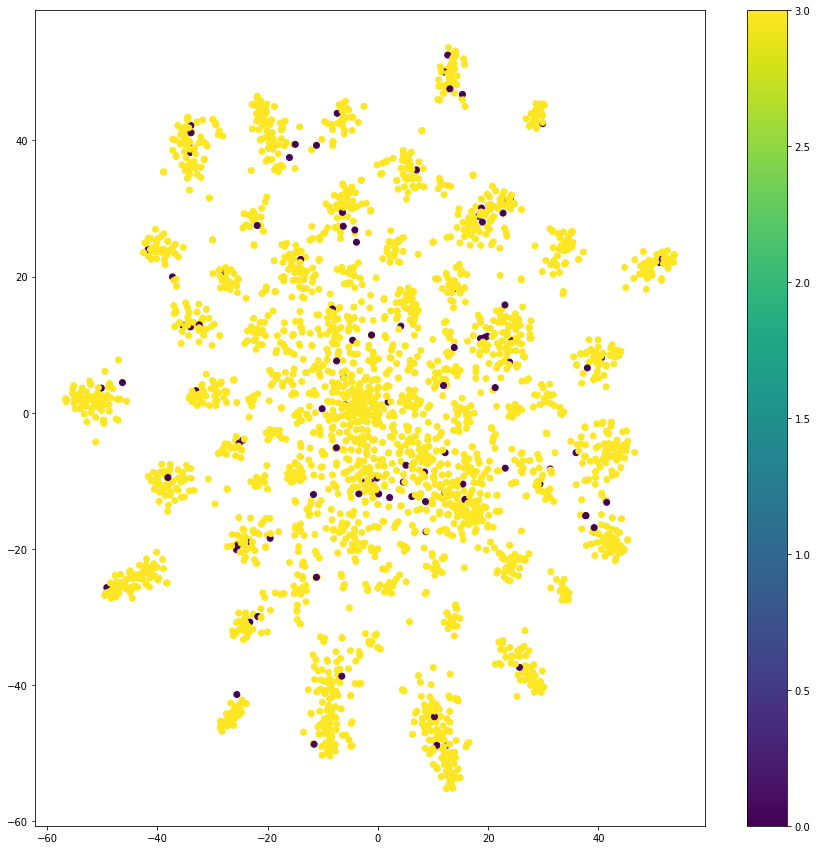

In [140]:
# plot the result
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(X_mnf, 0)[:, 3]
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

In [122]:
params = {'clf_ntopics': 3,
 'clf_ntopwords': 10,
 'clf_merge':True,
 'clf_serie':['TText', 'TTitle'],
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'nmf_alpha':0,
 'nmf_l1_ratio':0,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1),
}

customNMF = CustomNMF(**params)

parameters = {'clf_ntopwords': [5],
              'clf_merge': [True, False],
              'clf_serie':[['TText', 'TTitle'], ['TText', 'TTitle', 'TCode']],
              'nmf_alpha':np.arange(0,.251,.125/2),
              'nmf_l1_ratio':np.arange(0,.1251,.125/3),
             }


clf = GridSearchCV(customNMF, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 80 candidates, totalling 160 fits
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0 
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0 
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=49.58333333333333, total=  36.2s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=49.58333333333333, total=  36.6s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_rati

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.5min


[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0416666666667, score=53.333333333333336, total=  30.1s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0, score=60.16666666666667, total=  53.2s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333, score=39.25, total=  30.4s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0

[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0, score=50.16666666666666, total= 1.2min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667, score=48.916666666666664, total=  45.7s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667, score=46.66666666666667, total=  34.2s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_

[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.125, score=30.783333333333335, total=  46.4s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0, score=30.583333333333336, total=  51.5s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0, score=34.2, total=  43.4s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667, score=27.750000000000004, total=  32.5s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'T

[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.25, nmf_l1_ratio=0.125, score=33.166666666666664, total=  39.2s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=40.56666666666667, total= 1.2min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=33.416666666666664, total= 1.3min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 


[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 27.1min


[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=33.416666666666664, total= 1.3min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=40.56666666666667, total= 1.2min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.125 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333, score=33.416666666666664, total= 1.3min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.125 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333, score=40.56666666666667, tota

[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0, score=33.75000000000001, total=  41.5s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0, score=33.31666666666667, total=  42.4s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667, score=36.583333333333336, total=  45.2s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_n

[Parallel(n_jobs=3)]: Done 160 out of 160 | elapsed: 37.6min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=10, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0, nmf_init='nndsvd',
     nmf_l1_ratio=0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngr...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=5,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'clf_ntopwords': [5], 'clf_merge': [True, False], 'clf_serie': [['TText', 'TTitle'], ['TText', 'TTitle', 'TCode']], 'nmf_alpha': array([ 0.    ,  0.0625,  0.125 ,  0.1875,  0.25  ]), 'nmf_l1_ratio': array([ 0.     ,  0.04167,  0.08333,  0.125  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [123]:
clf.best_score_

55.083333333333336

In [124]:
clf.best_params_

{'clf_merge': True,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0}

In [125]:
{**params, **clf.best_params_}

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1)}

## Gridsearch to optimize tags research

In [149]:
#Metrics creation

scorer = make_scorer(f1_score, average='micro')
#scorer = make_scorer(label_ranking_average_precision_score, needs_proba=False)
#scorer = {'f1':make_scorer(f1_score, average='micro'), 'lra':make_scorer(label_ranking_average_precision_score, needs_proba=True)}


In [150]:
params = {'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
}

customNMF = CustomNMF(**params)

parameters = {'vect_1_max_df': [1., .95, .9],
              'vect_1_min_df': [1, 10, 20],
              'vect_1_max_features':[15000, 12000, 17000],
              'vect_1_ngram_range':[(1,1)],
             }


clf = GridSearchCV(customNMF, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring=scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1), score=0.10527192471058548, total=  17.4s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1), score=0.12707482993197278, total=  15.1s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.12309310889005787, total=  10.2s
[CV] vect_1_max_df=1.0, vect_1_max_features=150

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  4.5min


[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=1, vect_1_ngram_range=(1, 1), score=0.14601217991048498, total=  38.6s
[CV] vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.12309310889005787, total=  11.3s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.08793723439032362, total=  13.5s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=1, vect_1_ngram_range=(1, 1), score=0.10944282359638512, total=  57.4s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:  8.9min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_init='nndsvd',
     nmf_l1_ratio=0.0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_...,
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'vect_1_max_df': [1.0, 0.95, 0.9], 'vect_1_min_df': [1, 10, 20], 'vect_1_max_features': [15000, 12000, 17000], 'vect_1_ngram_range': [(1, 1)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [151]:
clf.best_score_

0.13083838411285659

In [152]:
clf.best_params_

{'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1)}

In [156]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.10378569136990697

In [157]:
mlb.inverse_transform(clf.predict(X_test))

[('function', 'lambda'),
 ('function', 'lambda'),
 ('npm', 'pip'),
 (),
 ('filter', 'function', 'lambda'),
 ('file',),
 ('api', 'rest'),
 ('null',),
 ('ajax', 'browser', 'csv', 'http', 'post'),
 ('post', 'wordpress'),
 ('browser', 'input', 'pdf'),
 ('filter', 'javascript', 'object'),
 ('null', 'pdf'),
 ('ajax', 'http', 'post'),
 ('ajax', 'http', 'input', 'post'),
 ('filter', 'pdf'),
 ('api', 'rest', 'server', 'sql'),
 ('button',),
 ('button', 'mysql'),
 ('docker', 'laravel', 'mysql', 'php', 'wordpress'),
 ('browser', 'django', 'join', 'mysql', 'sql', 'tensorflow'),
 ('filter', 'go', 'list', 'null'),
 ('npm', 'pip'),
 (),
 ('filter', 'javascript', 'null', 'object'),
 ('angular',),
 ('date', 'graph', 'input', 'plot'),
 ('browser', 'session'),
 ('django', 'filter', 'input', 'javascript', 'object', 'tensorflow'),
 ('angular',),
 ('function', 'lambda'),
 ('email', 'server', 'sql'),
 ('graph', 'pip', 'plot', 'python'),
 ('class',),
 (),
 (),
 ('audio', 'redirect', 'url', 'video'),
 ('filter'

In [158]:
mlb.inverse_transform(y_test)

[('image-processing', 'matlab'),
 ('javascript',),
 ('npm', 'reactjs'),
 ('c++', 'c++11'),
 ('arrays', 'c', 'multidimensional-array'),
 ('maven',),
 ('api', 'rest'),
 ('javascript', 'react-native', 'react-redux'),
 ('android',),
 ('css3', 'html5', 'jquery'),
 ('ajax', 'caching', 'javascript', 'php'),
 ('reactjs',),
 ('class', 'python-3.x', 'tkinter', 'user-interface'),
 ('jquery',),
 ('ajax', 'input', 'jquery'),
 ('php', 'woocommerce', 'wordpress'),
 ('node.js', 'socket.io', 'websocket'),
 ('android', 'android-recyclerview', 'filter', 'java'),
 ('c#', 'sql-server'),
 ('heroku', 'php'),
 ('performance', 'ruby-on-rails'),
 ('pandas', 'python'),
 ('haskell',),
 ('android-intent', 'xamarin.forms'),
 ('matrix',),
 ('angularjs', 'javascript'),
 ('charts', 'd3.js', 'javascript'),
 ('django', 'sql-server', 'transactions'),
 ('javascript',),
 ('angular',),
 ('sql-server',),
 ('python', 'sockets'),
 ('matplotlib', 'python'),
 ('c#', 'ios', 'xamarin', 'xamarin.ios'),
 ('neo4j',),
 ('c++', 'tensor